# パッケージインストール

In [1]:
!pip install -U -q "google-genai>=1.16.0"

# APIキー設定
Colaboratoryのシークレットに「GEMINI_API_KEY」を設定すること<br>
APIキーは[Google AI Studio](https://aistudio.google.com/u/1/apikey)から取得

In [2]:
import os
from google.colab import userdata

gemini_api_key = userdata.get('GEMINI_API_KEY')

In [3]:
from google import genai
from google.genai import types

# Geminiクライアント生成
client = genai.Client(api_key=gemini_api_key)

# モデル選択

In [4]:
model_name = "gemini-2.5-flash-preview-05-20"

# サンプル画像ダウンロード

In [5]:
# 雨の都市風景、 横断歩道と歩行者（https://www.pakutaso.com/20230815222post-48102.html）
!wget https://user0514.cdnw.net/shared/img/thumb/09.Night_Snap_1_TP_V4.jpg -O sample.jpg

--2025-07-23 00:28:15--  https://user0514.cdnw.net/shared/img/thumb/09.Night_Snap_1_TP_V4.jpg
Resolving user0514.cdnw.net (user0514.cdnw.net)... 172.233.66.71
Connecting to user0514.cdnw.net (user0514.cdnw.net)|172.233.66.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 103751 (101K) [image/jpeg]
Saving to: ‘sample.jpg’

sample.jpg          100%[===================>] 101.32K   231KB/s    in 0.4s    

2025-07-23 00:28:16 (231 KB/s) - ‘sample.jpg’ saved [103751/103751]



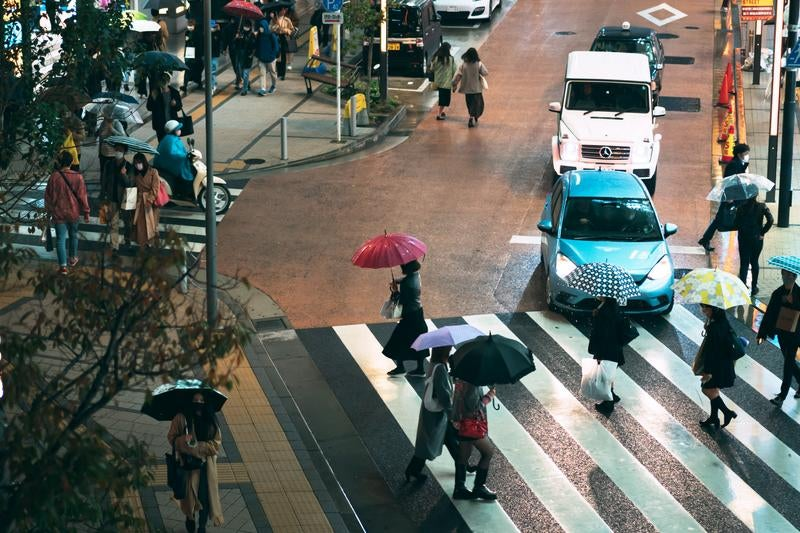

In [7]:
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow

bgr_image = cv2.imread("sample.jpg")

# アスペクト比を維持しつつ、長辺が1024になるようにリサイズ
image_height, image_width = bgr_image.shape[:2]
scale = min(1024 / image_width, 1024 / image_height, 1.0)
resize_bgr_image = cv2.resize(bgr_image, (int(image_width * scale), int(image_height * scale)), interpolation=cv2.INTER_LANCZOS4)

# 入力画像
input_image = Image.fromarray(cv2.cvtColor(resize_bgr_image, cv2.COLOR_BGR2RGB))

# 表示
cv2_imshow(resize_bgr_image)

# 物体検出

In [8]:
object_detection_system_instructions = """
    Return bounding boxes as a JSON array with labels. Never return masks or code fencing. Limit to 50 objects.
    If an object is present multiple times, name them according to their unique characteristic (colors, size, position, unique characteristics, etc..).
"""

In [9]:
safety_settings = [
    types.SafetySetting(
        category="HARM_CATEGORY_DANGEROUS_CONTENT",
        threshold="BLOCK_ONLY_HIGH",
    ),
]

In [11]:
prompt = 'Detect the 2D bounding boxes of all objects and include a detailed description as the label.'

# 物体検出実行
response = client.models.generate_content(
    model=model_name,
    contents=[prompt, input_image],
    config = types.GenerateContentConfig(
        system_instruction=object_detection_system_instructions,
        temperature=0.5,
        safety_settings=safety_settings,
        thinking_config=types.ThinkingConfig(
          thinking_budget=0  # No Thinking
        )
    )
)

print(response.text)

```json
[
  {"box_2d": [75, 532, 225, 574], "label": "person wearing a light green and black striped shirt and black pants"},
  {"box_2d": [286, 52, 510, 114], "label": "person wearing a red long-sleeved shirt and blue jeans"},
  {"box_2d": [90, 567, 241, 614], "label": "person wearing a light brown jacket and dark pants"},
  {"box_2d": [288, 151, 467, 215], "label": "person wearing a light brown coat and holding a pink bag"},
  {"box_2d": [256, 117, 452, 172], "label": "person wearing a dark coat and holding a black umbrella"},
  {"box_2d": [21, 319, 172, 362], "label": "person wearing a dark blue jacket and light blue jeans"},
  {"box_2d": [32, 278, 178, 321], "label": "person wearing a dark jacket and jeans"},
  {"box_2d": [90, 171, 267, 230], "label": "person wearing a dark coat and holding a black umbrella"},
  {"box_2d": [269, 874, 469, 946], "label": "person wearing a black jacket and holding a white umbrella"},
  {"box_2d": [355, 915, 559, 968], "label": "person wearing a black

In [12]:
import re
import json

# json ... で囲まれた部分だけ抜き出す
match = re.search(r"json\s*(\[\s*{.*?}\s*\])\s*", response.text, re.DOTALL)
if match:
    try:
        # JSONパース
        detections = json.loads(match.group(1))
    except json.JSONDecodeError as e:
        print("JSON decode error:", e)
        detections = []
else:
    print("No JSON block found.")
    detections = []

print(detections)

[{'box_2d': [75, 532, 225, 574], 'label': 'person wearing a light green and black striped shirt and black pants'}, {'box_2d': [286, 52, 510, 114], 'label': 'person wearing a red long-sleeved shirt and blue jeans'}, {'box_2d': [90, 567, 241, 614], 'label': 'person wearing a light brown jacket and dark pants'}, {'box_2d': [288, 151, 467, 215], 'label': 'person wearing a light brown coat and holding a pink bag'}, {'box_2d': [256, 117, 452, 172], 'label': 'person wearing a dark coat and holding a black umbrella'}, {'box_2d': [21, 319, 172, 362], 'label': 'person wearing a dark blue jacket and light blue jeans'}, {'box_2d': [32, 278, 178, 321], 'label': 'person wearing a dark jacket and jeans'}, {'box_2d': [90, 171, 267, 230], 'label': 'person wearing a dark coat and holding a black umbrella'}, {'box_2d': [269, 874, 469, 946], 'label': 'person wearing a black jacket and holding a white umbrella'}, {'box_2d': [355, 915, 559, 968], 'label': 'person wearing a black coat and holding a white umb

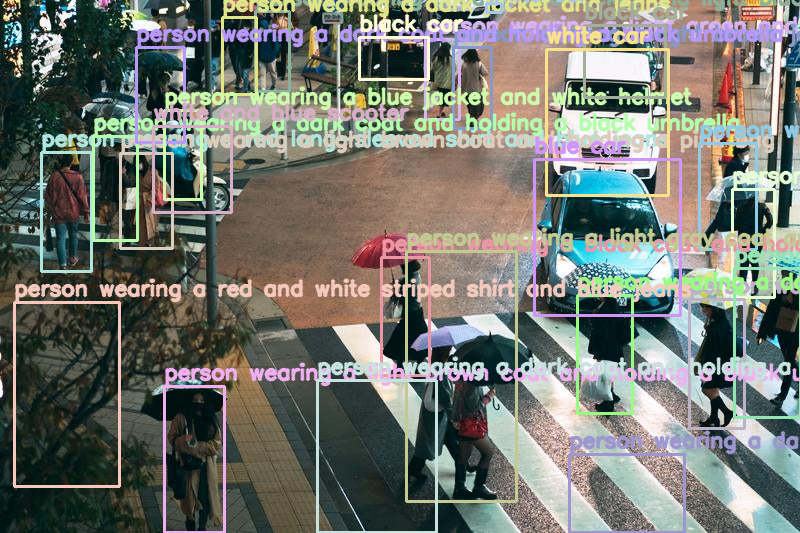

In [13]:
height, width = bgr_image.shape[:2]
debug_image = bgr_image.copy()

def get_id_color(index: int) -> tuple[int, int, int]:
    temp_index = abs(int(index + 1)) * 3
    r = (37 * temp_index) % 128
    g = (17 * temp_index) % 128
    b = (29 * temp_index) % 128
    pastel_color = (r + 128, g + 128, b + 128)
    return pastel_color

# 各検出物体を描画
for index, detection_info in enumerate(detections):
    box = detection_info.get("box_2d")
    label = detection_info.get("label", "unknown")
    if box and len(box) == 4:
        # スケーリングされた座標（0～1000）を元の画像サイズに変換
        y1 = int(box[0] / 1000 * height)
        x1 = int(box[1] / 1000 * width)
        y2 = int(box[2] / 1000 * height)
        x2 = int(box[3] / 1000 * width)

        color = get_id_color(index)
        cv2.rectangle(debug_image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(
            debug_image,
            label,
            (x1, max(y1 - 7, 0)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            color,
            2,
            cv2.LINE_AA
        )

# 表示
cv2_imshow(debug_image)

# 物体検出

In [14]:
prompt = 'Find the woman with the red umbrella.'

# 物体検出実行
response = client.models.generate_content(
    model=model_name,
    contents=[prompt, input_image],
    config = types.GenerateContentConfig(
        system_instruction=object_detection_system_instructions,
        temperature=0.5,
        safety_settings=safety_settings,
        thinking_config=types.ThinkingConfig(
          thinking_budget=0  # No Thinking
        )
    )
)

print(response.text)

```json
[
  {"box_2d": [488, 477, 703, 536], "label": "the woman with the red umbrella"}
]
```


In [15]:
import re
import json

# json ... で囲まれた部分だけ抜き出す
match = re.search(r"json\s*(\[\s*{.*?}\s*\])\s*", response.text, re.DOTALL)
if match:
    try:
        # JSONパース
        detections = json.loads(match.group(1))
    except json.JSONDecodeError as e:
        print("JSON decode error:", e)
        detections = []
else:
    print("No JSON block found.")
    detections = []

print(detections)

[{'box_2d': [488, 477, 703, 536], 'label': 'the woman with the red umbrella'}]


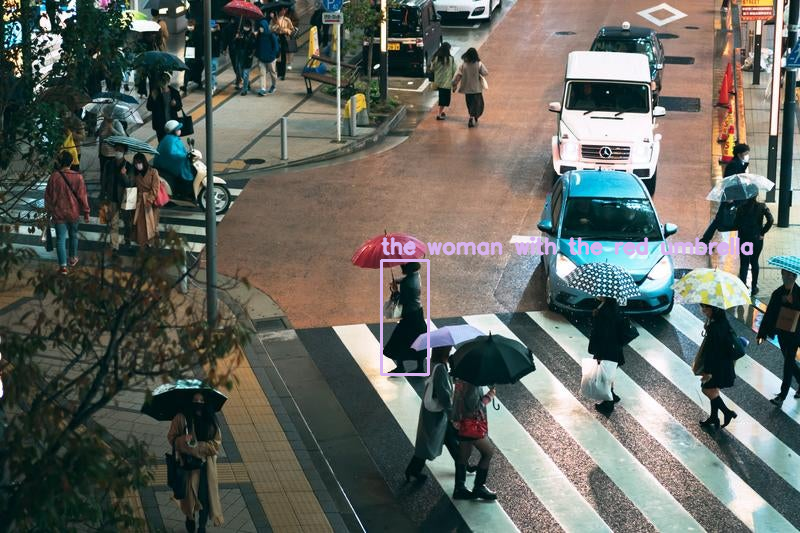

In [16]:
height, width = bgr_image.shape[:2]
debug_image = bgr_image.copy()

def get_id_color(index: int) -> tuple[int, int, int]:
    temp_index = abs(int(index + 1)) * 3
    r = (37 * temp_index) % 128
    g = (17 * temp_index) % 128
    b = (29 * temp_index) % 128
    pastel_color = (r + 128, g + 128, b + 128)
    return pastel_color

# 各検出物体を描画
for index, detection_info in enumerate(detections):
    box = detection_info.get("box_2d")
    label = detection_info.get("label", "unknown")
    if box and len(box) == 4:
        # スケーリングされた座標（0～1000）を元の画像サイズに変換
        y1 = int(box[0] / 1000 * height)
        x1 = int(box[1] / 1000 * width)
        y2 = int(box[2] / 1000 * height)
        x2 = int(box[3] / 1000 * width)

        color = get_id_color(index)
        cv2.rectangle(debug_image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(
            debug_image,
            label,
            (x1, max(y1 - 7, 0)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            color,
            2,
            cv2.LINE_AA
        )

# 表示
cv2_imshow(debug_image)

# セグメンテーション

```json
[
  {"box_2d": [314, 668, 592, 852], "mask": "", "label": "the car"},
  {"box_2d": [100, 680, 368, 835], "mask": "", "label": "the car"},
  {"box_2d": [46, 730, 192, 833], "mask": "", "label": "the car"},
  {"box_2d": [0, 532, 54, 630], "mask": "", "label": "the car"},
  {"box_2d": [206, 915, 426, 1000], "mask": "", "label": "the car"},
  {"box_2d": [0, 447, 150, 552], "mask": "", "label": "the car"}
]
```

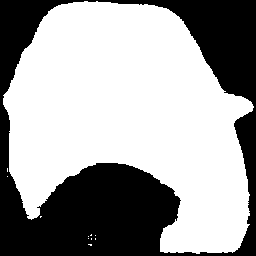
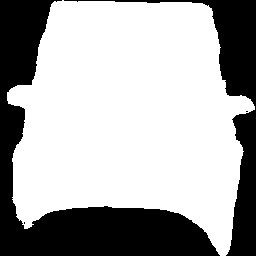
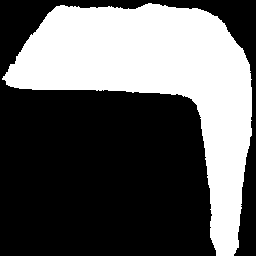
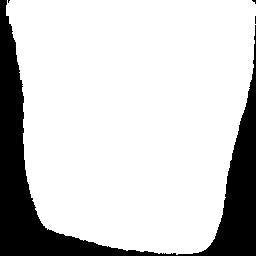
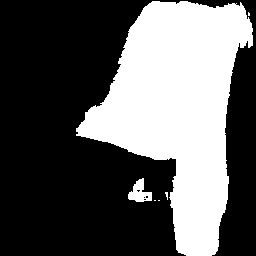
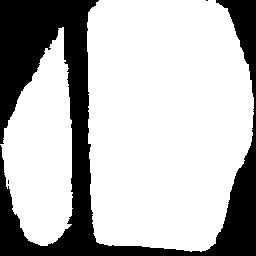

In [17]:
prompt = "Give the segmentation masks for the car. Output a JSON list of segmentation masks where each entry contains the 2D bounding box in the key \"box_2d\", the segmentation mask in key \"mask\", and the text label in the key \"label\". Use descriptive labels."

# セグメンテーション実行
response = client.models.generate_content(
    model=model_name,
    contents=[prompt, input_image],
    config = types.GenerateContentConfig(
        temperature=0.5,
        safety_settings=safety_settings,
        thinking_config=types.ThinkingConfig(
          thinking_budget=0
        )
    )
)

print(response.text)

[{'box_2d': [314, 668, 592, 852], 'mask': '', 'label': 'the car'}, {'box_2d': [100, 680, 368, 835], 'mask': '', 'label': 'the car'}, {'box_2d': [46, 730, 192, 833], 'mask': '', 'label': 'the car'}, {'box_2d': [0, 532, 54, 630], 'mask': '', 'label': 'the car'}, {'box_2d': [206, 915, 426, 1000], 'mask': '', 'label': 'the car'}, {'box_2d': [0, 447, 150, 552], 'mask': '', 'label': 'the car'}]

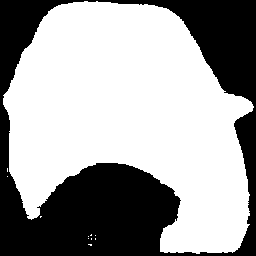
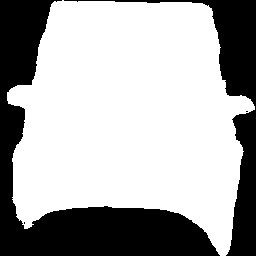
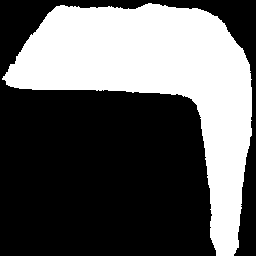
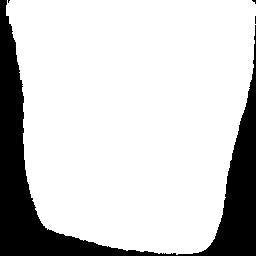
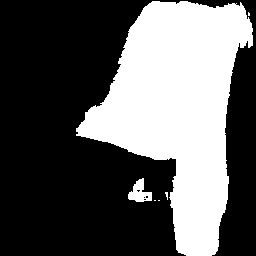
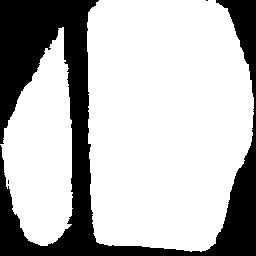

In [18]:
import re
import json

# json ... で囲まれた部分だけ抜き出す
match = re.search(r"json\s*(\[\s*{.*?}\s*\])\s*", response.text, re.DOTALL)
if match:
    try:
        # JSONパース
        detections = json.loads(match.group(1))
    except json.JSONDecodeError as e:
        print("JSON decode error:", e)
        detections = []
else:
    print("No JSON block found.")
    detections = []

print(detections)

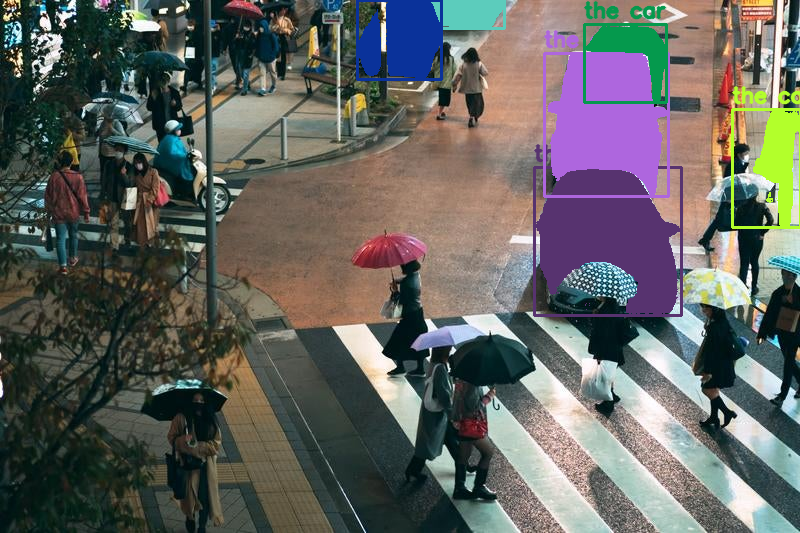

In [38]:
import cv2
import numpy as np
import base64
from PIL import Image
from io import BytesIO
from google.colab.patches import cv2_imshow  # Colab用

height, width = bgr_image.shape[:2]
debug_image = bgr_image.copy()

def get_id_color(index: int) -> tuple[int, int, int]:
    temp_index = abs(int(index + 1)) * 3
    r = (37 * temp_index) % 256
    g = (17 * temp_index) % 256
    b = (29 * temp_index) % 256
    return (r, g, b)

def decode_mask(base64_str: str, target_shape: tuple[int, int]) -> np.ndarray:
    """base64 PNG文字列をデコードし、指定サイズにリサイズして2値化されたマスクを返す"""
    if base64_str.startswith("data:image"):
        base64_str = base64_str.split(",")[1]
    mask_data = base64.b64decode(base64_str)
    pil_image = Image.open(BytesIO(mask_data)).convert("L")
    mask_np = np.array(pil_image)
    mask_resized = cv2.resize(mask_np, (target_shape[1], target_shape[0]), interpolation=cv2.INTER_NEAREST)
    binary_mask = (mask_resized > 128).astype(np.uint8)  # しきい値処理
    return binary_mask

# 各検出物体を描画
# 各検出物体を描画
for index, detection_info in enumerate(detections):
    box = detection_info.get("box_2d")
    label = detection_info.get("label", "unknown")
    mask_b64 = detection_info.get("mask")

    if box and len(box) == 4:
        y1 = int(box[0] / 1000 * height)
        x1 = int(box[1] / 1000 * width)
        y2 = int(box[2] / 1000 * height)
        x2 = int(box[3] / 1000 * width)

        color = get_id_color(index)
        cv2.rectangle(debug_image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(
            debug_image,
            label,
            (x1, max(y1 - 7, 0)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            color,
            2,
            cv2.LINE_AA
        )

        # セグメンテーションマスクを塗りつぶしで描画
        if mask_b64:
            mask_small = decode_mask(mask_b64, (y2 - y1, x2 - x1))
            for c in range(3):
                debug_image[y1:y2, x1:x2, c][mask_small == 1] = color[c]

# 表示
cv2_imshow(debug_image)